#### Get data

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [96]:
transcript_input_file = "../Datasets/transcript.csv"
customer_profile_file = "../Data Processing/customer_profile_df.csv"
offers_file = "../Data Processing/offers_df.csv"

# Data containing transaction information
transcript_df= pd.read_csv(transcript_input_file, index_col=0)
transactions_df = transcript_df.copy()[transcript_df["event"] == "transaction"].reset_index(drop=True)
# Extract amount
transactions_df["amount"] = [eval(value_dict).get("amount") for value_dict in transactions_df["value"]]
# Round to amount 2 dp
transactions_df["amount"] = round(transactions_df["amount"], 2)
# Drop event and value columns
transactions_df = transactions_df.drop(columns=["event", "value"])

# Data containing customer information
customer_profile_raw = pd.read_csv(customer_profile_file, index_col=0)
customer_profile_df = customer_profile_raw.copy()
customer_profile_df["became_member_on"] = pd.to_datetime(customer_profile_df["became_member_on"], format="%Y-%m-%d")

# Data containing offer information
offers_raw = pd.read_csv(offers_file, index_col=0)
offers_df = offers_raw.copy()

#### Obtain prior transaction and offer information

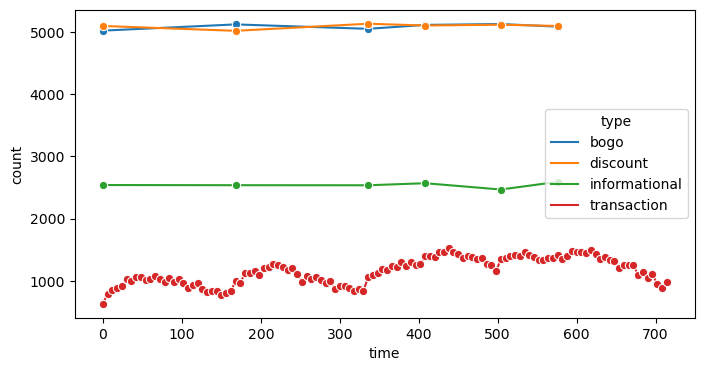

In [97]:
# Check data

# Transactions over time
txn_over_time_df = transactions_df.groupby("time")["amount"].count().reset_index(name="count")
txn_over_time_df["type"] = "transaction"

# Offers over time
offers_over_time_df = offers_df.copy()[["person", "offer_id", "received_time", "offer_completed", "offer_type"]].groupby([
    "received_time", "offer_type"])["person"].count().reset_index(name="count").rename(columns={"offer_type": "type", "received_time": "time"})
combined_over_time_df = pd.concat([offers_over_time_df, txn_over_time_df])

plt.figure(figsize=(8, 4))
sns.lineplot(data=combined_over_time_df, x="time", y="count", hue="type", marker="o")
plt.show()

- 6 waves of offers 
- Times: Wk 1: 0, Wk 2: 168, Wk 3: [336, 408], Wk 4: [504, 576]

In [98]:
# Join time and amount as tuple
transactions_df["time_amt"] = list(zip(transactions_df["time"], transactions_df["amount"]))
# Group records by person
transactions_person_df = transactions_df.copy().groupby("person", sort=True)["time_amt"].apply(list).reset_index(name="time_amt_list")
# Join transaction information (person-level) to offers dataframe
offers_w_txn_df = offers_df.merge(transactions_person_df, on="person", how="left")
# Fill na with empty list
offers_w_txn_df["time_amt_list"] = offers_w_txn_df["time_amt_list"].fillna("").apply(list)

# Group offers by person
offers_person_df = offers_df.copy()[["person", "received_time"]].groupby("person")["received_time"].apply(list).reset_index(name="received_time_list")
# Join offer information (person-level) to offers dataframe
offers_w_txn_df = offers_w_txn_df.merge(offers_person_df, on="person", how="left")

def get_past_txn_offer_info(row):
    received_time = row["received_time"]
    full_time_amt_list = row["time_amt_list"]

    # Initialise values
    last_txn_time = 715 # use 715 to denote time of last txn when there was no last txn
    time_since_last_txn = 715 # use 715 to denote time since last txn when there was no last txn
    last_txn_amt = 0
    ave_txn_amt = 0
    num_txn_past_week = 0
    past_week_cutoff = max(received_time - (7*24), 0)

    # Only retain transactions that occurred before offer received
    filtered_time_amt_list = list(filter(lambda x: x[0] <= received_time, full_time_amt_list))

    if len(filtered_time_amt_list) > 0:
        # Extract txn_time and txn_amt from filtered list into tuples
        txn_times, txn_amts = list(zip(*filtered_time_amt_list))
        # Obtain info of last transaction
        last_txn_time = txn_times[-1]
        time_since_last_txn = received_time - last_txn_time
        last_txn_amt = txn_amts[-1]
        # Obtain frequency of transactions in the past week (7 days)
        num_txn_past_week = len(list(filter(lambda x: x >= past_week_cutoff, txn_times)))
        # Obtain average amount per txn
        ave_txn_amt = round(np.mean(txn_amts), 2)

    # Obtain frequency of offers in the past week (7 days)
    full_received_time_list = row["received_time_list"]
    # Only retain offers that occurred in 7 days prior to offer received 
    filtered_received_time_list = list(filter(
        lambda x: past_week_cutoff <= x < received_time, full_received_time_list))
    num_offers_past_week = len(filtered_received_time_list)

    return (last_txn_time, time_since_last_txn, last_txn_amt, ave_txn_amt, num_txn_past_week, num_offers_past_week)

In [99]:
# Initialise holder lists
last_txn_time_list = []
time_since_last_txn_list =[]
last_txn_amt_list = []
ave_txn_amt_list = []
num_txn_past_week_list = []
num_offers_past_week_list = []

for index, row in offers_w_txn_df.iterrows():
    last_txn_time, time_since_last_txn, last_txn_amt, ave_txn_amt, num_txn_past_week, num_offers_past_week = get_past_txn_offer_info(row)
    last_txn_time_list.append(last_txn_time)
    time_since_last_txn_list.append(time_since_last_txn)
    last_txn_amt_list.append(last_txn_amt)
    ave_txn_amt_list.append(ave_txn_amt)
    num_txn_past_week_list.append(num_txn_past_week)
    num_offers_past_week_list.append(num_offers_past_week)

offers_w_txn_df["last_txn_time"] = last_txn_time_list
offers_w_txn_df["time_since_last_txn"] = time_since_last_txn_list
offers_w_txn_df["last_txn_amt"] = last_txn_amt_list
offers_w_txn_df["ave_txn_amt"] = ave_txn_amt_list
offers_w_txn_df["num_txn_past_week"] = num_txn_past_week_list
offers_w_txn_df["num_offers_past_week"] = num_offers_past_week_list

#### Combine data

In [100]:
# Match transaction amount to offer completed records
offers_w_txn_customer_df = offers_w_txn_df.merge(transactions_df, left_on=["person", "completed_time"], right_on=["person", "time"], how="left")
offers_w_txn_customer_df["txn_amt"] = offers_w_txn_customer_df["amount"]
offers_w_txn_customer_df = offers_w_txn_customer_df.drop(columns=["amount", "time", "time_amt"])
# Match customer profile to offer records
offers_w_txn_customer_df = offers_w_txn_customer_df.merge(customer_profile_df.copy()[["person", "gender", "age", "income"]], on="person")

In [101]:
segment_file = "../Segmentation Analysis/merged_segmented.csv"
# Data containing assigned segment information
segment_df = pd.read_csv(segment_file, usecols=["person", "cluster"])
segment_df = segment_df.groupby("person")["cluster"].agg(pd.Series.mode).reset_index(name="segment")
segment_df["segment"] = segment_df["segment"].astype(str)
# Match assigned segement
offers_w_txn_customer_df = offers_w_txn_customer_df.merge(segment_df, on="person", how="left")

In [102]:
# Select relevant columns for analysis
id_cols = ["person", "offer_id"]
customer_profile_cols = ["gender", "age", "income"]
offer_details_num_cols = ["reward", "difficulty", "duration", "num_channels", "txn_amt"]
offer_details_bool_cols = ["used_email", "used_web", "used_social", "used_mobile", "offer_viewed"]
offer_details_cat_cols = ["offer_type"]
time_cols = ["received_time"]
past_txn_offer_cols = ["time_since_last_txn", "last_txn_amt", "ave_txn_amt", "num_txn_past_week", "num_offers_past_week"]

relevant_cols = ["offer_completed", "segment"] + id_cols + customer_profile_cols + offer_details_num_cols + offer_details_bool_cols + offer_details_cat_cols + time_cols + past_txn_offer_cols
combined_df = offers_w_txn_customer_df.copy()[relevant_cols]

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_completed       66501 non-null  int64  
 1   segment               65020 non-null  object 
 2   person                66501 non-null  object 
 3   offer_id              66501 non-null  object 
 4   gender                66501 non-null  object 
 5   age                   66501 non-null  int64  
 6   income                66501 non-null  float64
 7   reward                66501 non-null  int64  
 8   difficulty            66501 non-null  int64  
 9   duration              66501 non-null  int64  
 10  num_channels          66501 non-null  int64  
 11  txn_amt               32444 non-null  float64
 12  used_email            66501 non-null  int64  
 13  used_web              66501 non-null  int64  
 14  used_social           66501 non-null  int64  
 15  used_mobile        

In [103]:
# Fill in missing values for segment
segment_mode = combined_df["segment"].mode()[0]
combined_df["segment"] = combined_df["segment"].fillna(segment_mode)

In [104]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_completed       66501 non-null  int64  
 1   segment               66501 non-null  object 
 2   person                66501 non-null  object 
 3   offer_id              66501 non-null  object 
 4   gender                66501 non-null  object 
 5   age                   66501 non-null  int64  
 6   income                66501 non-null  float64
 7   reward                66501 non-null  int64  
 8   difficulty            66501 non-null  int64  
 9   duration              66501 non-null  int64  
 10  num_channels          66501 non-null  int64  
 11  txn_amt               32444 non-null  float64
 12  used_email            66501 non-null  int64  
 13  used_web              66501 non-null  int64  
 14  used_social           66501 non-null  int64  
 15  used_mobile        

In [105]:
# Save to csv file
combined_df.to_csv("reg_combined_df.csv")